# Data Storytelling Summary
## Overview

The story of poverty in New York City is primarily about people and income. Within that, a wide variety of factors such as age, location, disability status, ability to speak English, the size and composition of an apartment or home -- even factors that the data only hint at -- play a key role.

We'll look quickly at the dataset, do a little housekeeping, and then jump into the visualizations with comments.

Note that, since our dataset has annual data from 2005-2016, most of these charts will be time slices from 2005, 2010, and 2016 for comparison across time.

## The Dataset

* Data from https://data.cityofnewyork.us/browse?q=poverty
* 12 annual data files, from 2005 to 2016 inclusive (e.g. NYCgov_Poverty_Measure_Data__2016_.csv)
* CSV files with ~80 columns and ~60,000 rows each
* Each file had essentially the same format and contained (mostly) the same information
* Data types included:
    * Classification types encoded as integers (e.g. 1 if in poverty, 2 if not in poverty)
    * Floats for financial data (e.g. wages for the calendar year)

## Housekeeping part 1: imports and file prep

In order to make charts more easily, after importing we'll make some quick modifications to the data.

In [1]:
# imports and setup
from os import listdir
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, hsv_to_rgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('data/all_years.csv', index_col=0)

# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']
id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']
nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']
output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

# Create a dataframe 'cats' that uses categorical coding, rather than numerical coding, based on the dictionaries above.
cats = df.replace(nyc_codes)
cats = cats.replace(raw_codes)
cats = cats.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}, 
                     'Off_Pov_Stat': {1:'Pov', 2:'Not Pov'}, 
                     'AgeCateg': {1: 'U18', 2:'18-64', 3:'65+'}})

# Update one column so that NA's are all in one category
cats.loc[cats['HIUnit_Head'].isna(), 'HIUnit_Head'] = 'NA'

# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
per_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork'] 
hh_vars = ['NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_EITC', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']


## Housekeeping part 2: helper functions

In [2]:
def df_for_pov_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of weighted poverty rate by a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of weighted poverty rate by the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', ['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
    else:
        counts = dataframe[['NYCgov_Pov_Stat', column, weights_column]].groupby([column, 'NYCgov_Pov_Stat']).sum()
        
    # count and create % poverty by column    
    subtotals = counts.sum(level=0)
    pcts = 100 * counts / subtotals
    pcts = pcts.unstack('NYCgov_Pov_Stat')
    
    # only return the % in poverty by column
    return pd.DataFrame(pcts[weights_column]['Pov'])

def df_for_stat_chart(dataframe, column, weights_column):
    '''Creates a chart-ready dataframe of a single category in a column.
    Input: a dataframe, the name of the column of interest, and the name of the column containing the appropriate weights.
    Output: a chart-ready dataframe of the category of interest.'''
    
    # If the weight is by household, need to filter by household head
    if weights_column == 'WGTP':
        counts = dataframe.loc[dataframe['Povunit_Rel'] == 'Head', [column, weights_column]].groupby(column).sum()
    else:
        counts = dataframe[[column, weights_column]].groupby(column).sum()
        
    # count and create % by column    
    subtotals = counts.sum(level=0)
    pcts = subtotals/sum(counts[weights_column])
    
    # only return the % in poverty by column
    return pcts

def scatter_combined(dataframe, column, ylim=35):
    '''Create a scatter plot of weighted poverty rate by a single column, all years combined.
    Input: a dataframe, a column name, and an optional upper y-limit for the chart.
    Output: no return value. Plots a scatter plot.'''
    
    # Set up initial variables
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create counts and percentages by column
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts = pcts.rename(columns={'Pov': 'Weighted Poverty Rate by ' + str(column) + ', All Years Combined'})

    # Show the chart
    chart = sns.scatterplot(data=pcts)
    chart.set_ylim(0,ylim)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    pass

def scatter_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple scatter plots of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(3)):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y='Pov', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
            
def scatter_sub_stat(dataframe, column, years=[2005, 2010, 2016], ylimits=[0,0.25]):
    '''Create multiple scatter plots of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple scatter subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip(years, range(3)):
        # If no data for that year, don't try to make a chart
        if len(dataframe.loc[(dataframe.Year == year) & (dataframe[column].notna())]) > 0:
            pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight).reset_index()
            ax = pcts.plot(kind='scatter', x=column, y=weight, title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis])
            ax.grid(which='major', axis='y')
            plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()])
            ax.set_ylim(ylimits[0], ylimits[1])
            
def bar_combined(dataframe, column):
    '''Create a bar chart of weighted poverty rate by a single column, all years combined.
    Input: a dataframe and a column name.
    Output: no return value. Plots a bar chart.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'
    pcts = df_for_pov_chart(dataframe, column, weight)
    pcts.plot.bar(title='Weighted Poverty Rate by ' + str(column) + ', All Years Combined', legend=None, color='bgrcymk')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    
def bar_sub(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of weighted poverty rate by a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip([2005, 2010, 2016], range(3)):
        pcts = df_for_pov_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Poverty Rate by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
        
def bar_sub_stat(dataframe, column, years=[2005, 2010, 2016]):
    '''Create multiple bar charts of a column, over certain years.
    Input: a dataframe, a column name, and an optional list of years.
    Output: no return value. Plots multiple bar subplots.'''
    
    weight = 'PWGTP' if column in per_vars else 'WGTP'

    # Create the charts
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
    for year, axis in zip([2005, 2010, 2016], range(3)):
        pcts = df_for_stat_chart(dataframe.loc[dataframe.Year == year], column, weight)
        ax = pcts.plot(kind='bar', title = 'Weighted Population by ' + column + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
        ax.grid(which='major', axis='y')
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

## Poverty Rate by Year

* The overall poverty rate was 19.5% in 2016.
    * From 20.3% in 2005, it increased to 20.6% in 2010 (after the recession), and decreased to 19.5% in 2016.
* The yearly decreases look small, but are important.
    * 0.1% decrease in poverty in NYC is about 8,500 people.

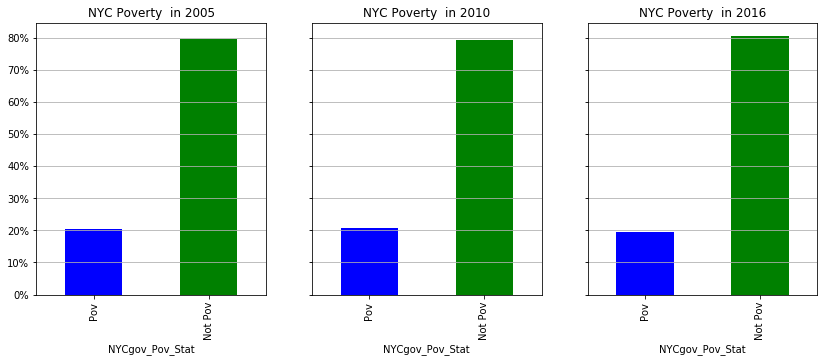

In [3]:
column = 'NYCgov_Pov_Stat'
weight = 'PWGTP'

# Create the charts
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharex=True, sharey=True)
for year, axis in zip([2005, 2010, 2016], range(3)):
    
    # count and create % by column    
    counts = df.loc[df.Year == year, [column, weight]].groupby(column).sum()
    pcts = 100 * counts / np.sum(counts)
    
    # chart by year
    ax = pcts.plot(kind='bar', title = 'NYC Poverty ' + ' in ' + str(year), ax=axes[axis], legend=None, color='bgrcymk')
    ax.grid(which='major', axis='y')
    plt.gca().set_xticklabels(['Pov', 'Not Pov'])
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 

## Age and Poverty Status

* Age has one of the largest impacts on poverty status.  
    * Note the cluster below age 25.
    * Above age 25 there appears to be a strong correlation with poverty rate.  
    * If you're in an age group with more than 22% poverty, you're either younger than 25 or over 60.

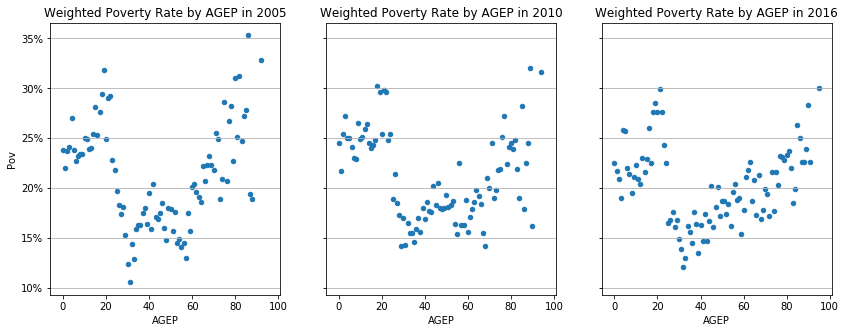

In [4]:
n = 0
scatter_sub(cats, raw_inp_vars[n])

* The distribution of population by age is also somewhat surprising:
    * Similar clustering between age < 25 and 25+ as in the poverty chart above.
    * 2005 and 2016 look very similar; the population is not significantly aging.
    * Birth rates and/or in-migration are keeping the population by age group relatively stable.
    * This is not the case in lots of other areas around the US.
* We'll dig into this further in EDA.

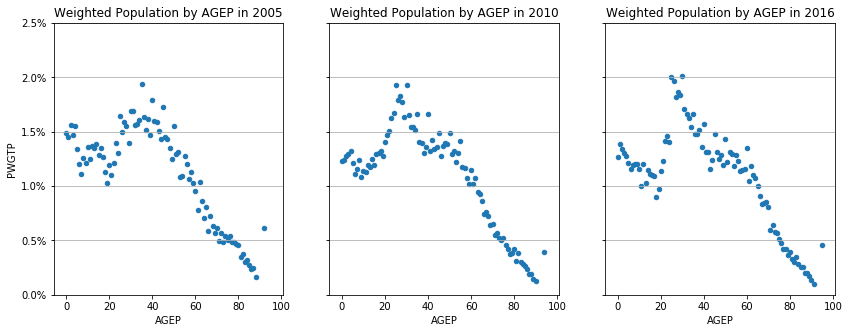

In [5]:
n = 0
scatter_sub_stat(cats, raw_inp_vars[n], ylimits=[0, 0.025])

## Age Category

* Here's another look by age; the disparity in poverty rates by group seems to have diminished since 2005.

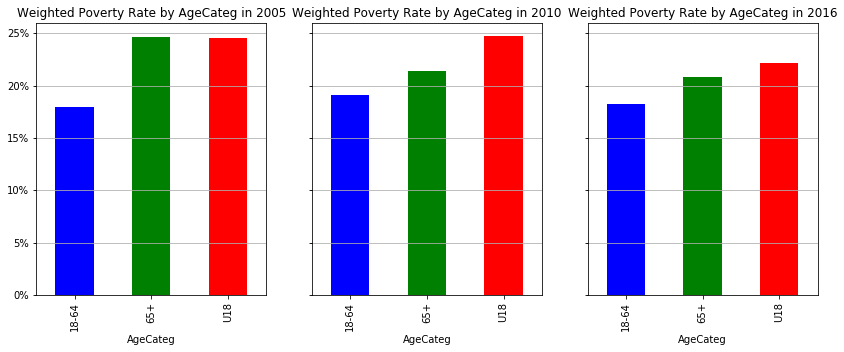

In [6]:
n = 0
bar_sub(cats, acs_vars[n])

## Borough

* New York City ("NYC") has five boroughs (see https://en.wikipedia.org/wiki/Boroughs_of_New_York_City), for which poverty rates have gone in different directions over time:
    * Poverty rates have decreased fairly dramatically in the Bronx and Brooklyn.
    * They have also decreased in Manhattan.
    * Poverty rates have increased in Queens and especially Staten Island.

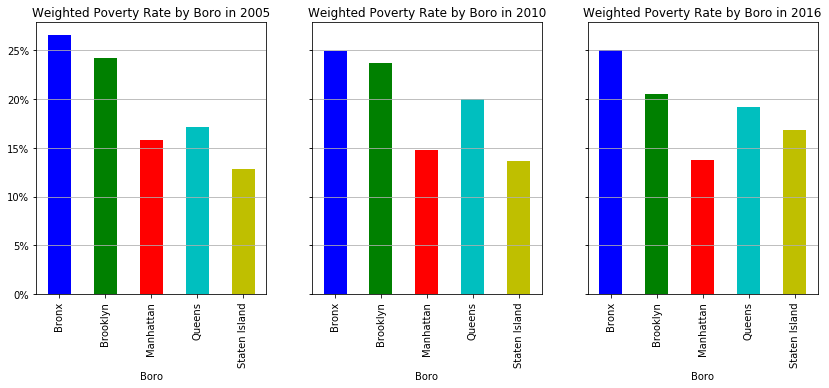

In [7]:
n = 1
bar_sub(cats, raw_inp_vars[n])

* Income varies dramatically by borough, as shown below.
    * I've focused in on the IQRs of the charts because outliers make the charts difficult to interpret.
    * Median pretax income in the Bronx is roughly *half* that of Staten Island. 
    * Median incomes by borough have increased roughly 25-33% over the 11-year period, though unevenly.  
    * Manhattan seems to have the most outliers (not shown on this chart).

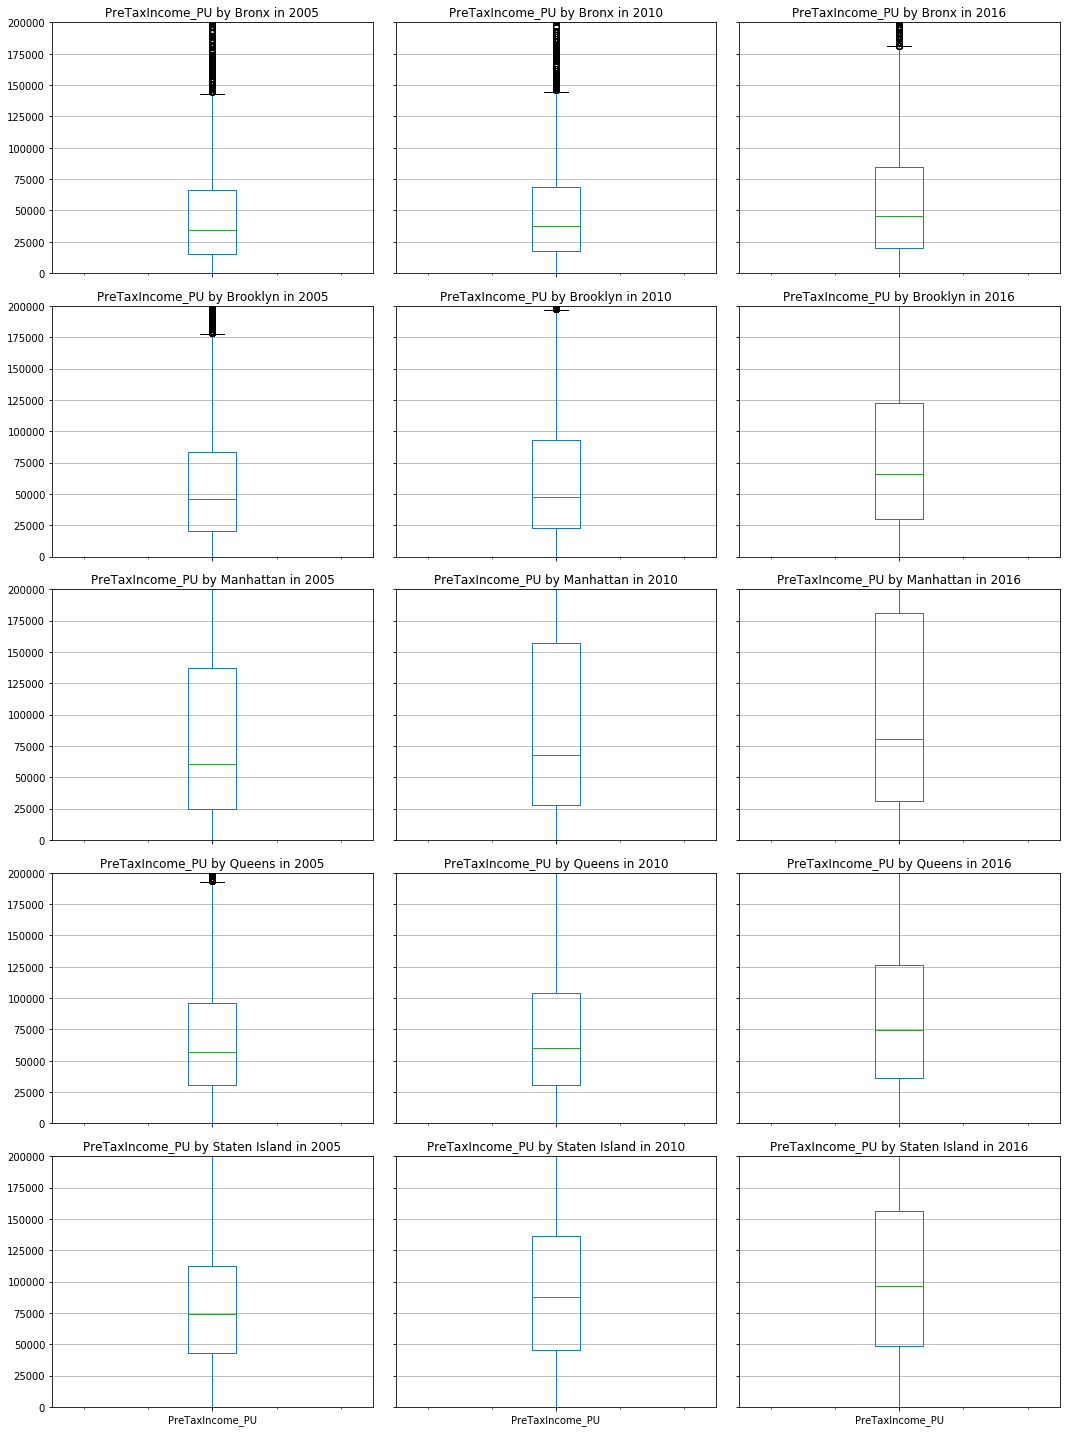

In [8]:
id = 'Boro'
group = raw_codes
target = 'PreTaxIncome_PU'
cols = 3
rows = len(group[id])
weight = 'PWGTP' if id in per_vars else 'WGTP'

fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(15)

for row in group[id]:
    for year, col_axis in zip([2005, 2010, 2016], range(cols)):
        foc_df = cats.loc[(cats[id] == group[id][row]) & (cats['Year'] == year), target]
        
        chart_title = title = str(target) + ' by ' + str(group[id][row]) + ' in ' + str(year)
        ax = foc_df.plot(kind='box', title = chart_title, ax=axes[row - 1, col_axis], ylim=(0,200000))
        ax.grid(which='major', axis='y')

plt.tight_layout()

* Population shares by borough have remained fairly consistent over time.
* Brooklyn and the Bronx (the two boroughs with the highest poverty) represent roughly half of NYC.

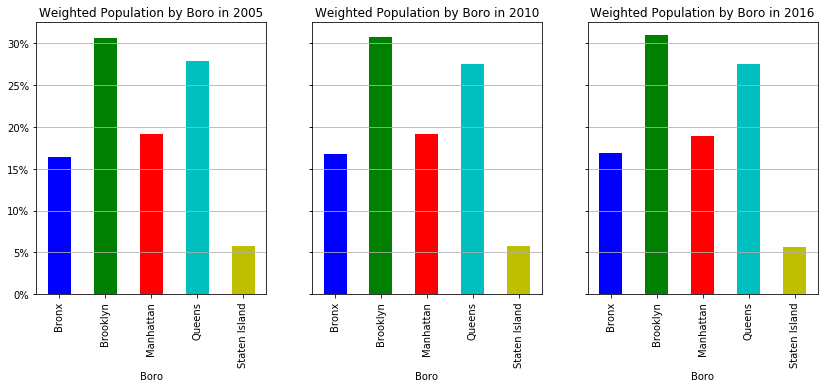

In [9]:
n = 1
bar_sub_stat(cats, raw_inp_vars[n])

## Total Work Hours by Poverty Unit ('TotalWorkHrs_PU')

* Households with at least the equivalent of one half-time worker have dramatically better poverty rates.

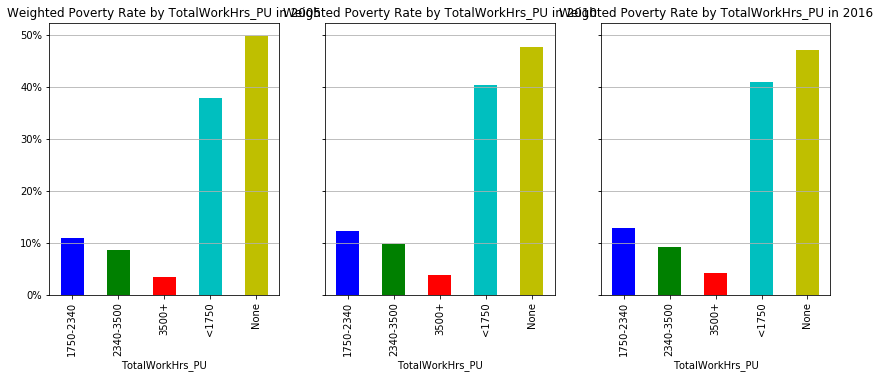

In [10]:
n = 30
bar_sub(cats, nyc_vars[n])

* About 35% of households don't have at least the equivalent of one half-time worker, a figure that's remained relatively stable through the years.

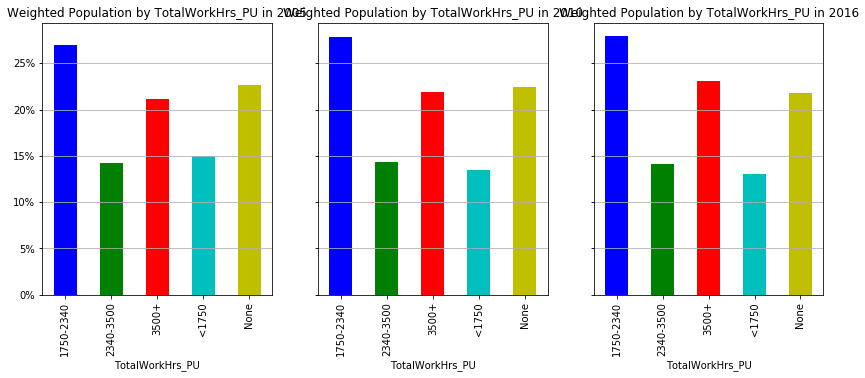

In [11]:
n = 30
bar_sub_stat(cats, nyc_vars[n])

## Usual Hours Worked ('WKHP')

* This statistic is *individual* hours worked; while there appears to be less poverty among those who work more, there are lots of outliers. Will need to dig deeper on income versus work hours.

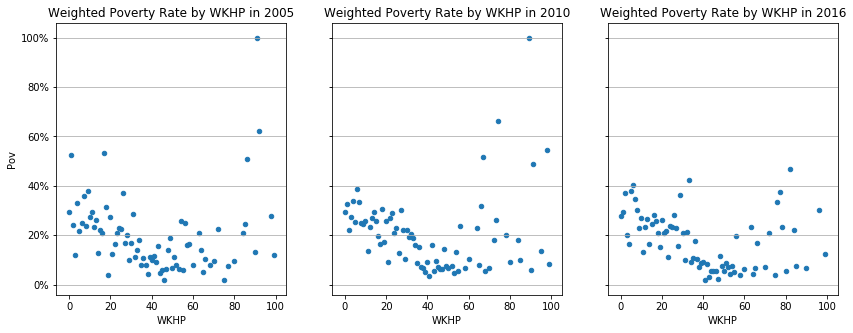

In [12]:
n = 23
scatter_sub(cats, raw_inp_vars[n])

## Weeks Worked Past 12 Months ('WKW')

* The chart by weeks worked past 12 months, also an individual stat, is suprising in that it looks almost exactly like you'd expect.

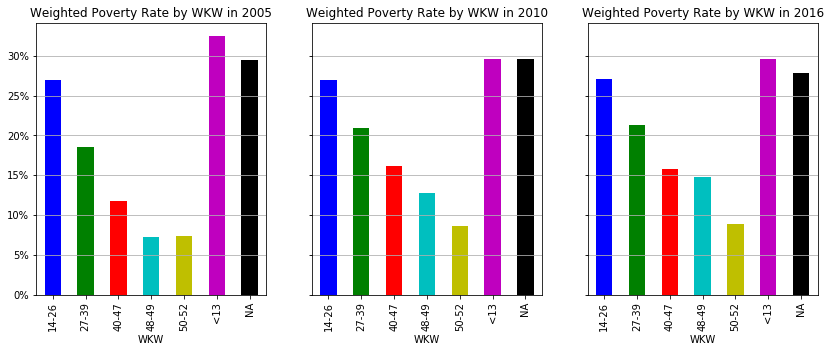

In [13]:
n = 24
bar_sub(cats, raw_inp_vars[n])

## Salary/Wages ('WAGP_adj')

* Salary/Wages has a fairly strong correlation with poverty level, but not as much as one might naively expect.
* Note the 'column' around WAGP_adj=0; the relationship appears somewhat linear outside of that, but with lots of noise.

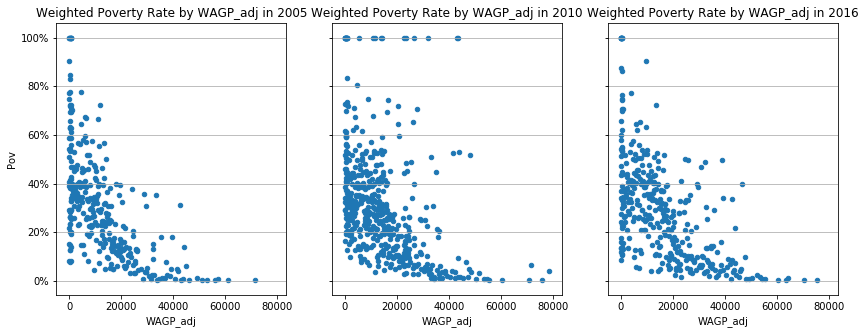

In [14]:
n = 10
scatter_sub(cats, acs_vars[n])

## Social Security ('SSP_adj')

* Note the 'column' from 0-2500, with no clear relationship between Social Security and poverty rate.
* Interestingly, above roughly 2500 dollars/year, there appears to be somewhat of a correlation.

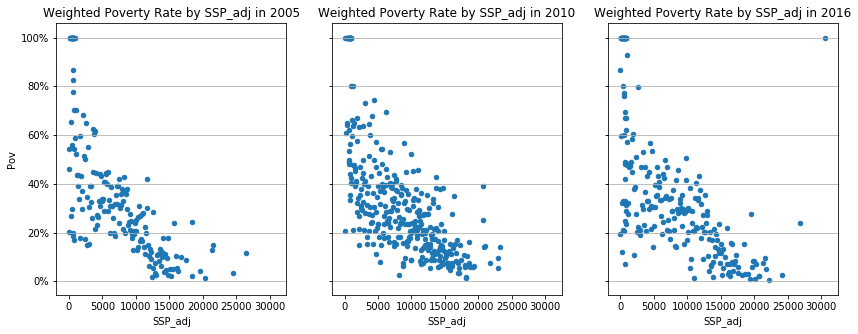

In [15]:
n = 9
scatter_sub(cats, acs_vars[n])

## Disability Status

* The poverty rate is much higher among the disabled than the non-disabled in 2010 and 2016.

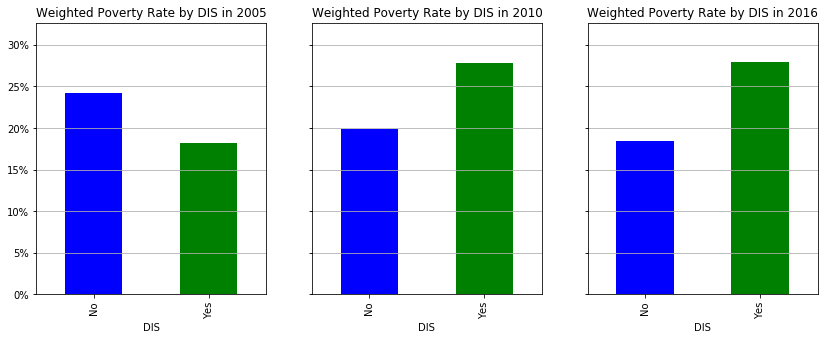

In [16]:
n = 3
bar_sub(cats, raw_inp_vars[n])

## Ethnicity

* Asian and Hispanic groups have higher poverty rates, and both groups continue to grow in share of population.

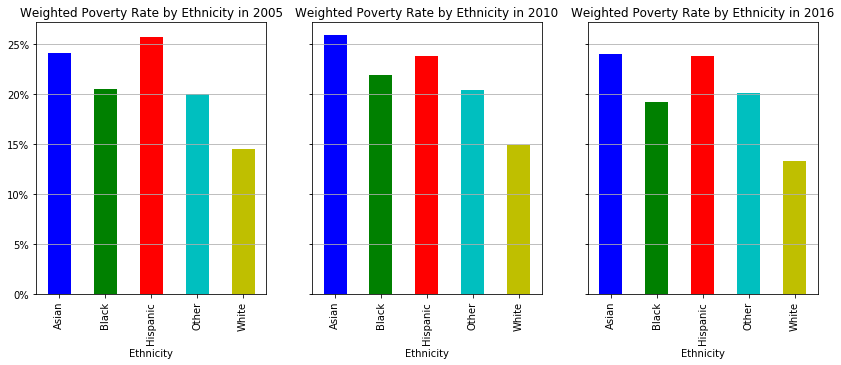

In [17]:
n = 6
bar_sub(cats, raw_inp_vars[n])

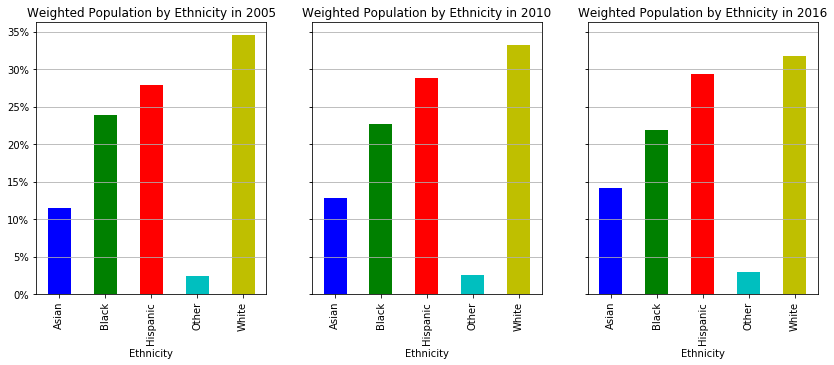

In [18]:
n = 6
bar_sub_stat(cats, raw_inp_vars[n])

## Citizenship Status

* Non-citizens have higher poverty incidence than citizens by birth or naturalized citizens.

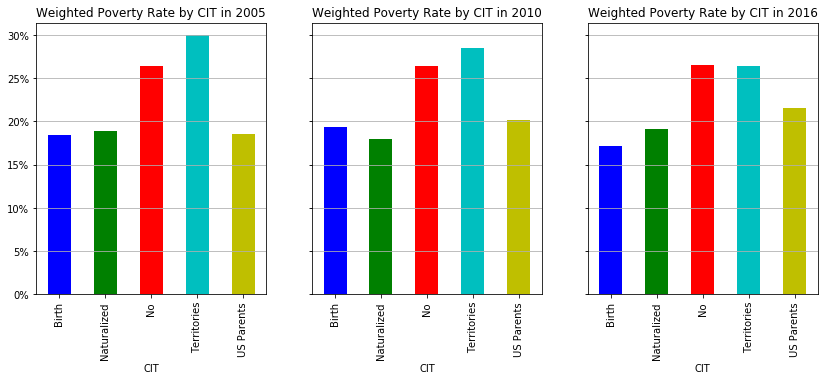

In [19]:
n = 2
bar_sub(cats, raw_inp_vars[n])

* The share of naturalized citizens has increased since 2005.

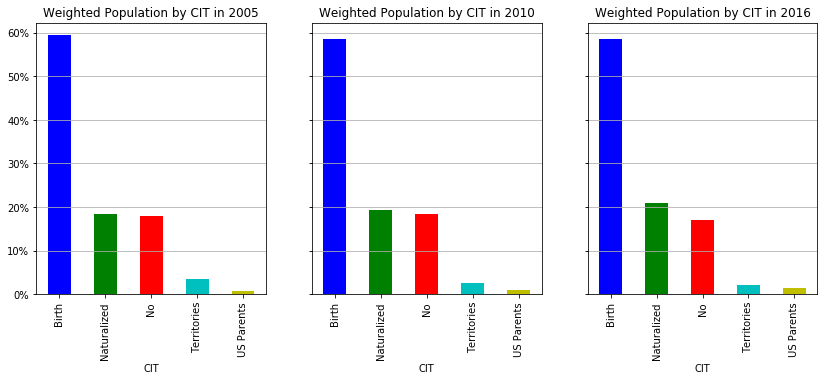

In [20]:
n = 2
bar_sub_stat(cats, raw_inp_vars[n])

## Family Type ('FamType_PU')

* Single parents or unrelated cohabitants are most likely to be in poverty.

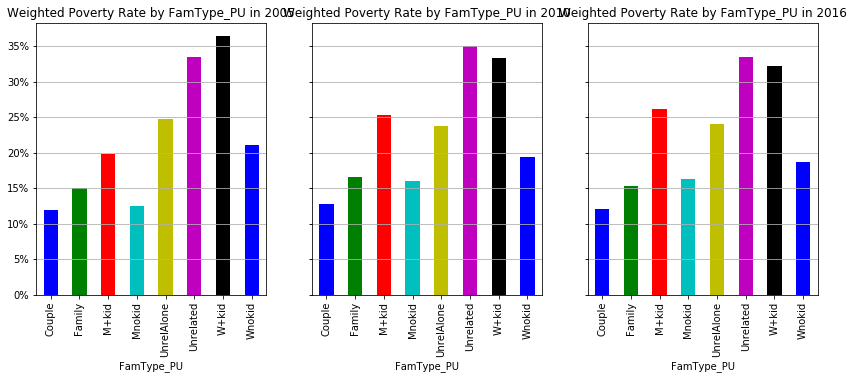

In [21]:
n = 3
bar_sub(cats, nyc_vars[n])

## Ability to Speak English

* Those who speak english well are less likely to be in poverty.

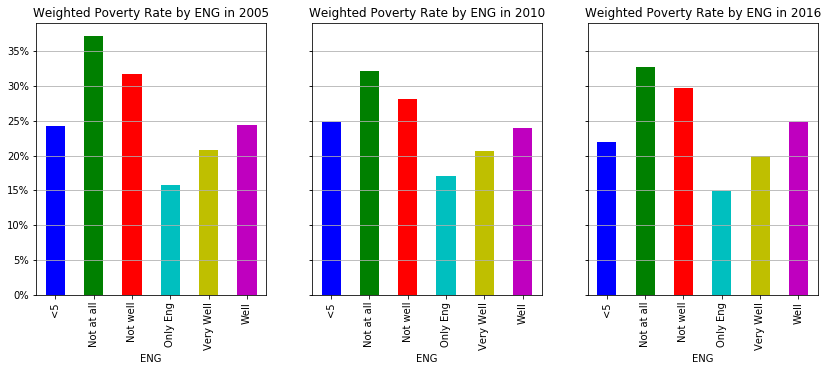

In [22]:
n = 4
bar_sub(cats, raw_inp_vars[n])

* Nearly 10% of the population speaks English "Not at All" or "Not Well".

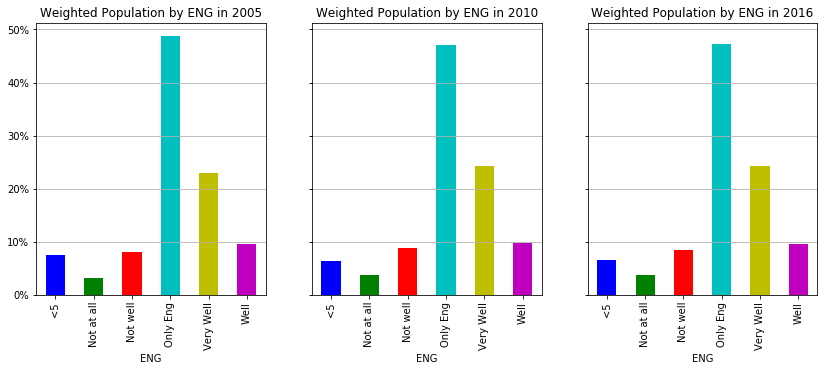

In [23]:
n = 4
bar_sub_stat(cats, raw_inp_vars[n])

## Employment Status Recode

* This is what you might expect; "Unemployed" and "Not in Labor Force" groups have the highest levels of poverty.

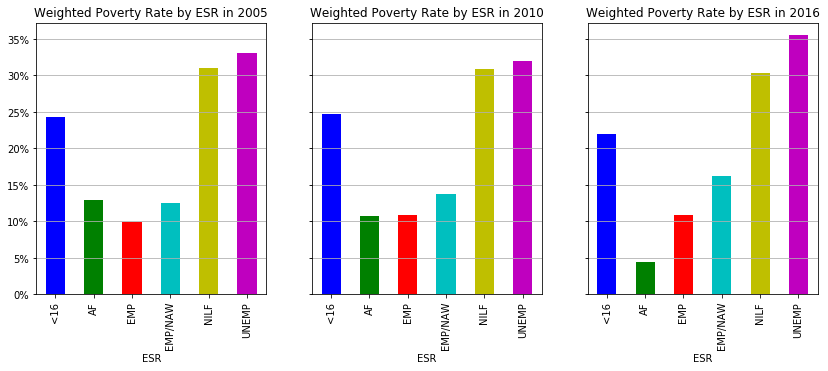

In [24]:
n = 5
bar_sub(cats, raw_inp_vars[n])

* Note that the rate of people that are unemployed is incredibly low.  Will need to check whether any of the NILF people could actually be in the labor force (many are presumably retirement-age, possibly disabled, etc.).

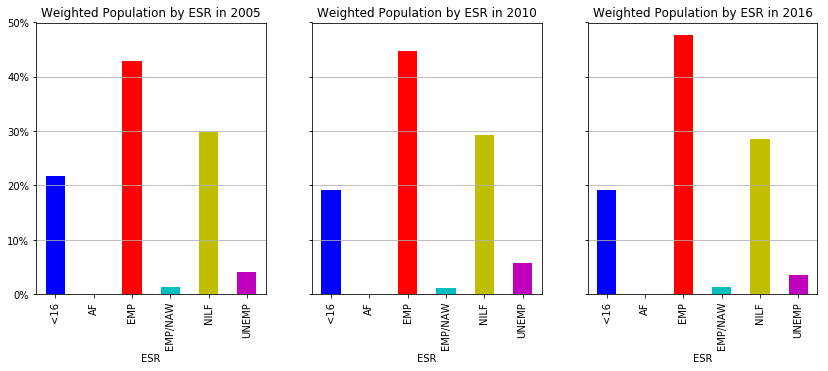

In [25]:
n = 5
bar_sub_stat(cats, raw_inp_vars[n])

## Housing Status

* Different subsidy statuses have different incidences of poverty. Why does "Own - Free & Clear" show higher poverty incidence than "Own - Mortgage"?

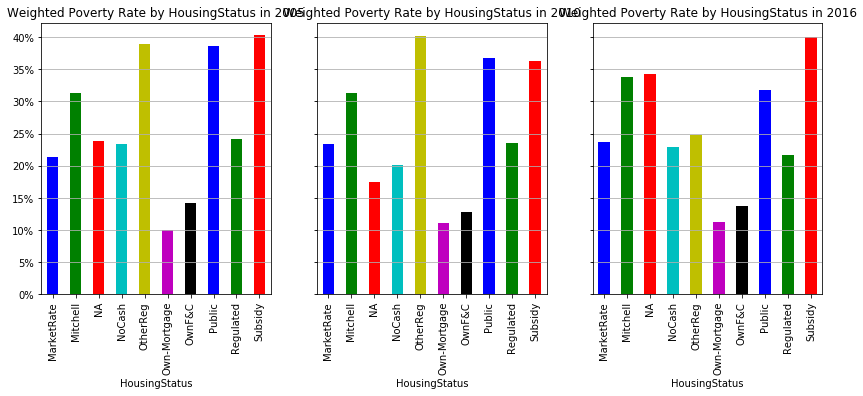

In [26]:
n = 9
bar_sub(cats, raw_inp_vars[n])

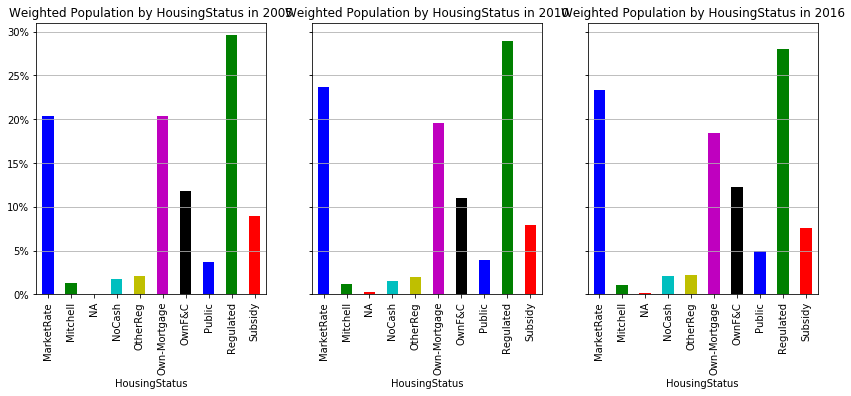

In [27]:
n = 9
bar_sub_stat(cats, raw_inp_vars[n])

## Housing Tenure ('TEN')

* Aside from the question previously noted about poverty rates among "Free & Clear" owners, poverty rates by housing tenure look similar to what you might expect.

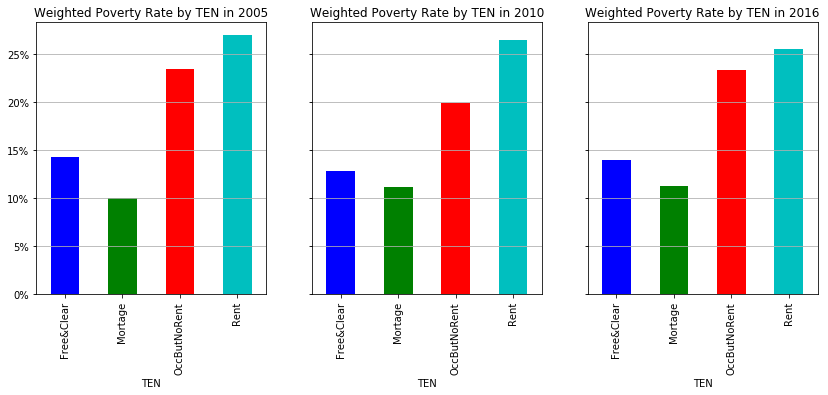

In [28]:
n = 22
bar_sub(cats, raw_inp_vars[n])

## Rent Payments ('RNTP_adj')

* Note the cluster below 1000 dollars/month, where there appears to be no discernible relationship between rent and poverty.
    * Recall the prior charts on housing status; subsidies make the relationship more complicated.
* Above roughly 1,000 dollars/month, the data looks roughly linear. 

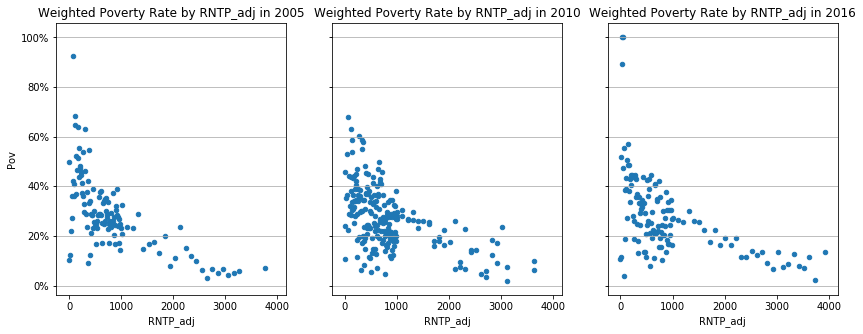

In [29]:
n = 6
scatter_sub(cats, acs_vars[n])

## Number of People in Household

* The poverty incidence among 1-person households seems strangely high.
    * Hypothesis: many older people living alone?  Will need to investigate.
* Other than that, more people correlates roughly with higher poverty.

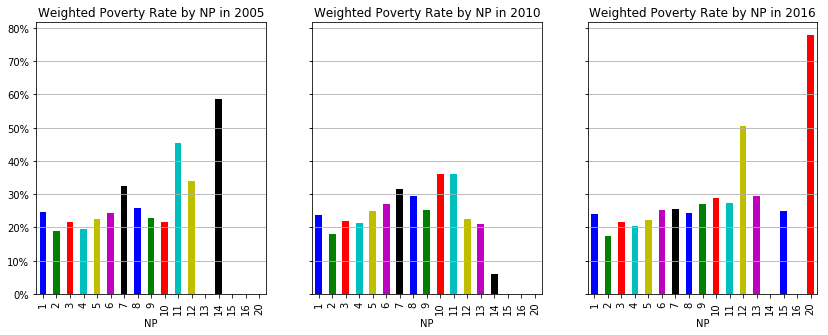

In [30]:
n = 14
bar_sub(cats, raw_inp_vars[n])

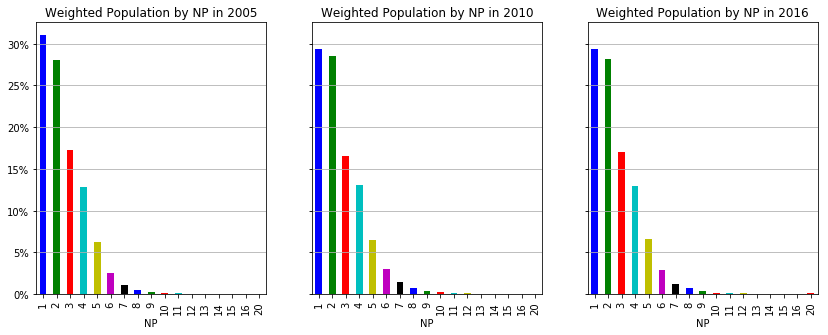

In [31]:
n = 14
bar_sub_stat(cats, raw_inp_vars[n])

## Educational Attainment ('EducAttain')

* Educational attainment correlates with poverty status as you would expect.
* The differences between "less than high school", a diploma, and some college have diminished slightly since 2005.

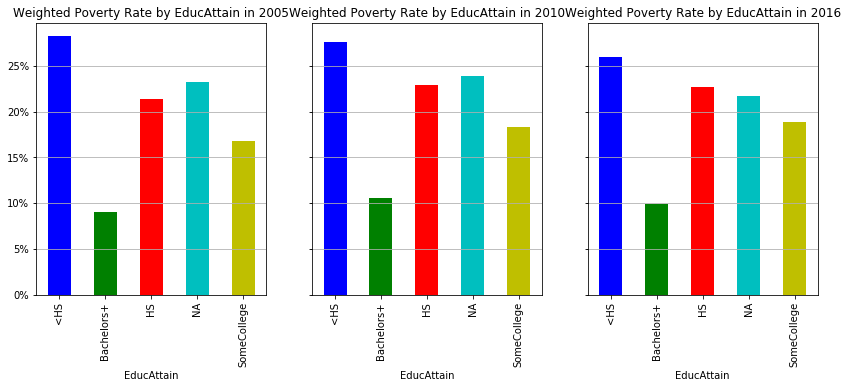

In [32]:
n = 1
bar_sub(cats, nyc_vars[n])

## Sex

* More women than men are in poverty.
    * Hypothesis/question: what percent of the difference could be explained by differences in child care duties between men and women, and what percentage to income gaps?

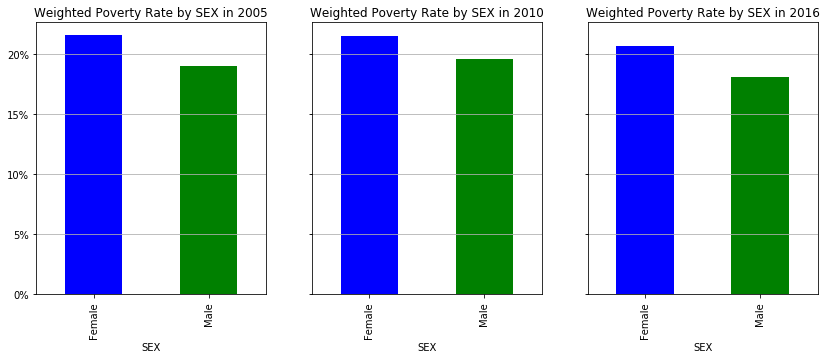

In [33]:
n = 21
bar_sub(cats, raw_inp_vars[n])